# LSTMとは

LSTMとは何なのかを簡潔に説明してください。  

説明に含める事項  

- SimpleRNNの持つ問題をどのように解決しているか  
- ゲートと呼ばれる仕組みについて

SimpleRNNの問題点は勾配爆発、勾配消失を起こすため、長期の時系列データではうまく学習を行うことができないことです。  
勾配爆発への対応策には**勾配クリッピング**という手法があり、ある一定の制約値を超えたら、大きくなりすぎた勾配を補正するというものです。  
一方で勾配消失への対応策として、outputゲート、forgetゲート、inputゲートを追加することが挙げられます。  
このゲートは簡単に言うと、**必要な情報だけ通す門**のことだと言えます。  
outputゲートとforgetゲートとinputゲートの使われ方の本質は全て同じで、違いは使われる場所だけです。  
tanhを通して得られる出力に対してはoutputゲートを用い、記憶セルに対して用いるのがforgetゲートであり、  
隠れ層と記憶セルを足し合わせる前に通すのがinputゲートです。  
全てやっていることは**必要な情報の取捨選択**です。使われる場所が違うだけです。  

隠れ層と記憶セルを足し合わせるという言葉が出てきましたが、
この他にアマダール積を用いて、行列の要素ごとの掛け算を行なったりもします。  
同じ重みを使った行列の積を繰り返すことで勾配爆発、または勾配消失を引き起こしていたのですが、  
行列の要素ごとに計算を行うアマダール積を用いることでそれを回避することができます。  
先ほどのゲートを通った出力には必要な情報が含まれています。  
必要な情報をアマダール積で掛け合わせることで、長期にわたって必要なデータを伝達することが可能になっています。

# スクラッチ

In [ ]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

## forward

In [ ]:
def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape
    
    A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
    
    f = sigmoid(A[:, :H])
    g = np.tanh(A[:, H:2*H])
    i　= sigmoid(A[:, 2*H:3*H])
    o = sigmoid(A[:, 3*H:])
    
    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)
    
    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

## backward

In [ ]:
def backward(self, dh_next, dc_next):
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache
    
    tanh_c_next = np.tanh(c_next)
    
    ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
    
    dc_prev = ds * f

    di = ds * g
    df = ds * c_prev
    do = dh_next * tanh_c_next
    dg = ds * i

    di *= i * (1 - i)
    df *= f * (1 - f)
    do *= o * (1 - o)
    dg *= (1 - g ** 2)

    dA = np.hstack((df, dg, di, do))

    dWh = np.dot(h_prev.T, dA)
    dWx = np.dot(x.T, dA)
    db = dA.sum(axis=0)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    dx = np.dot(dA, Wx.T)
    dh_prev = np.dot(dA, Wh.T)

    return dx, dh_prev, dc_prev

## TimeLSTM

In [ ]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, M), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros_like((N, H), dtype='f')
            
        if not self.stateful or self.c is None:
            self.c = np.zeros_like((N, H), dtype='f')
            
        for t in range(T):
            layer = LTSM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, M = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grad[i][...] = grad
            self.dh = dh
            return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    def reset_state(self):
        self.h, self.c = None, None

## 学習

In [1]:
import numpy as np
import sys
sys.path.append('./deep-learning-from-scratch-2')
from common.time_layers import *
import pickle
from ch06.rnnlm import Rnnlm
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.14
| epoch 1 |  iter 21 / 1327 | time 5[s] | perplexity 2527.26
| epoch 1 |  iter 41 / 1327 | time 11[s] | perplexity 1267.56
| epoch 1 |  iter 61 / 1327 | time 16[s] | perplexity 971.75
| epoch 1 |  iter 81 / 1327 | time 22[s] | perplexity 808.47
| epoch 1 |  iter 101 / 1327 | time 27[s] | perplexity 644.89
| epoch 1 |  iter 121 / 1327 | time 33[s] | perplexity 636.06
| epoch 1 |  iter 141 / 1327 | time 38[s] | perplexity 599.31
| epoch 1 |  iter 161 / 1327 | time 44[s] | perplexity 579.98
| epoch 1 |  iter 181 / 1327 | time 49[s] | perplexity 579.64
| epoch 1 |  iter 201 / 1327 | time 55[s] | perplexity 500.09
| epoch 1 |  iter 221 / 1327 | time 60[s] | perplexity 485.58
| epoch 1 |  iter 241 / 1327 | time 66[s] | perplexity 449.34
| epoch 1 |  iter 261 / 1327 | time 71[s] | perplexity 463.25
| epoch 1 |  iter 281 / 1327 | time 77[s] | perplexity 445.90
| epoch 1 |  iter 301 / 1327 | time 82[s] | perplexity 393.70
| epoch 1 | 

| epoch 2 |  iter 1281 / 1327 | time 828[s] | perplexity 123.31
| epoch 2 |  iter 1301 / 1327 | time 837[s] | perplexity 157.54
| epoch 2 |  iter 1321 / 1327 | time 847[s] | perplexity 152.14
| epoch 3 |  iter 1 / 1327 | time 850[s] | perplexity 160.51
| epoch 3 |  iter 21 / 1327 | time 859[s] | perplexity 143.66
| epoch 3 |  iter 41 / 1327 | time 869[s] | perplexity 134.84
| epoch 3 |  iter 61 / 1327 | time 878[s] | perplexity 128.00
| epoch 3 |  iter 81 / 1327 | time 888[s] | perplexity 115.88
| epoch 3 |  iter 101 / 1327 | time 898[s] | perplexity 105.38
| epoch 3 |  iter 121 / 1327 | time 907[s] | perplexity 114.66
| epoch 3 |  iter 141 / 1327 | time 917[s] | perplexity 127.09
| epoch 3 |  iter 161 / 1327 | time 926[s] | perplexity 142.13
| epoch 3 |  iter 181 / 1327 | time 936[s] | perplexity 149.72
| epoch 3 |  iter 201 / 1327 | time 945[s] | perplexity 140.98
| epoch 3 |  iter 221 / 1327 | time 955[s] | perplexity 139.72
| epoch 3 |  iter 241 / 1327 | time 965[s] | perplexity 13

| epoch 4 |  iter 1181 / 1327 | time 1592[s] | perplexity 95.81
| epoch 4 |  iter 1201 / 1327 | time 1598[s] | perplexity 83.76
| epoch 4 |  iter 1221 / 1327 | time 1603[s] | perplexity 74.13
| epoch 4 |  iter 1241 / 1327 | time 1609[s] | perplexity 91.84
| epoch 4 |  iter 1261 / 1327 | time 1614[s] | perplexity 93.06
| epoch 4 |  iter 1281 / 1327 | time 1620[s] | perplexity 89.67
| epoch 4 |  iter 1301 / 1327 | time 1625[s] | perplexity 110.83
| epoch 4 |  iter 1321 / 1327 | time 1630[s] | perplexity 110.14


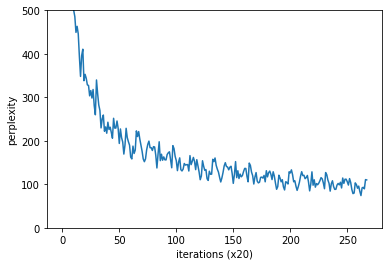

evaluating perplexity ...
234 / 235
test perplexity:  134.49613292491728


In [5]:
# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

# おまけ（TensorFlowでCBOWをやってみました）

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn
from tensorflow.python.framework import ops
# ops.reset_default_graph()

In [45]:
# Start a graph session
sess = tf.Session()

In [9]:
save_file_name = os.path.join('temp','temp_spam_data.csv')

# Create directory if it doesn't exist
if not os.path.exists('temp'):
    os.makedirs('temp')

if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    # And write to csv
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)

texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]

In [13]:
target

['ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'h

In [14]:
# Relabel 'spam' as 1, 'ham' as 0
target = [1 if x=='spam' else 0 for x in target]

In [15]:
target

[0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [16]:
# Normalize text
# Lower case
texts = [x.lower() for x in texts]

In [17]:
texts

['go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...',
 'ok lar... joking wif u oni...',
 "free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's",
 'u dun say so early hor... u c already then say...',
 "nah i don't think he goes to usf, he lives around here though",
 "freemsg hey there darling it's been 3 week's now and no word back! i'd like some fun you up for it still? tb ok! xxx std chgs to send, 1.50 to rcv",
 'even my brother is not like to speak with me. they treat me like aids patent.',
 "as per your request 'melle melle (oru minnaminunginte nurungu vettam)' has been set as your callertune for all callers. press *9 to copy your friends callertune",
 'winner!! as a valued network customer you have been selected to receivea 900 prize reward! to claim call 09061701461. claim code kl341. valid 12 hours only.',
 'had your 

In [18]:
# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

In [19]:
texts

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though',
 'freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send 150 to rcv',
 'even my brother is not like to speak with me they treat me like aids patent',
 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press 9 to copy your friends callertune',
 'winner as a valued network customer you have been selected to receivea 900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only',
 'had your mobile 11 months or more u r entitled to update to 

In [20]:
# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

In [21]:
texts

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in  a wkly comp to win fa cup final tkts st may  text fa to  to receive entry questionstd txt ratetcs apply overs',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though',
 'freemsg hey there darling its been  weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send  to rcv',
 'even my brother is not like to speak with me they treat me like aids patent',
 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press  to copy your friends callertune',
 'winner as a valued network customer you have been selected to receivea  prize reward to claim call  claim code kl valid  hours only',
 'had your mobile  months or more u r entitled to update to the latest colour mobiles with camera for free call

In [22]:
# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

In [23]:
texts

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though',
 'freemsg hey there darling its been weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send to rcv',
 'even my brother is not like to speak with me they treat me like aids patent',
 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press to copy your friends callertune',
 'winner as a valued network customer you have been selected to receivea prize reward to claim call claim code kl valid hours only',
 'had your mobile months or more u r entitled to update to the latest colour mobiles with camera for free call the mobil

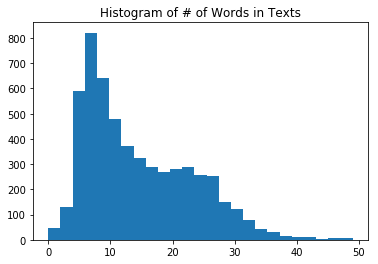

In [25]:
# Plot histogram of text lengths
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
plt.show()

In [26]:
# Choose max text word length at 25
sentence_size = 25
min_word_freq = 3

In [27]:
# Setup vocabulary processor
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [28]:
vocab_processor

In [29]:
# Have to fit transform to get length of unique words.
vocab_processor.transform(texts)
transformed_texts = np.array([x for x in vocab_processor.transform(texts)])
embedding_size = len(np.unique(transformed_texts))

Instructions for updating:
Please use tensorflow/transform or tf.data.


In [33]:
transformed_texts.shape, transformed_texts

((5574, 25), array([[   1,    2,    3, ...,    0,    0,    0],
        [  21,   22,   23, ...,    0,    0,    0],
        [  27,   28,    8, ...,   44,   45,   46],
        ...,
        [8161,  328,    8, ...,    0,    0,    0],
        [ 141, 2552,  224, ...,   32,  887,   83],
        [3379,   69, 1245, ...,    0,    0,    0]]))

In [36]:
embedding_size

8165

In [37]:
# Split up data set into train/test
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [38]:
# Setup Index Matrix for one-hot-encoding
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

In [39]:
identity_mat

<tf.Tensor 'Diag:0' shape=(8165, 8165) dtype=float32>

In [40]:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1], dtype=tf.float32)

In [41]:
# Text-Vocab Embedding
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

# Declare model operations
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

In [46]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Prediction operation
prediction = tf.sigmoid(model_output)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [47]:
# Start Logistic Regression
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%10==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
        
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 4459 Sentences.
Training Observation #10: Loss = 3.256938
Training Observation #20: Loss = 1.0947153e-07
Training Observation #30: Loss = 0.015348789
Training Observation #40: Loss = 0.00011673021
Training Observation #50: Loss = 3.6300836
Training Observation #60: Loss = 4.754706e-05
Training Observation #70: Loss = 0.0001549075
Training Observation #80: Loss = 0.66669667
Training Observation #90: Loss = 5.9068116e-05
Training Observation #100: Loss = 6.808283e-05
Training Observation #110: Loss = 2.7747444e-06
Training Observation #120: Loss = 0.00013414554
Training Observation #130: Loss = 6.6169124
Training Observation #140: Loss = 0.00012873365
Training Observation #150: Loss = 0.0003561595
Training Observation #160: Loss = 8.178085e-05
Training Observation #170: Loss = 0.011145783
Training Observation #180: Loss = 0.00010377367
Training Observation #190: Loss = 5.4461503e-07
Training Observation #200: Loss = 0.0010161621
Training Observation #210: Loss = 1.

Training Observation #1770: Loss = 0.00012465329
Training Observation #1780: Loss = 5.3210365e-06
Training Observation #1790: Loss = 0.0005425184
Training Observation #1800: Loss = 8.383991e-06
Training Observation #1810: Loss = 3.0453858
Training Observation #1820: Loss = 2.5931417e-05
Training Observation #1830: Loss = 0.009984366
Training Observation #1840: Loss = 7.909975e-05
Training Observation #1850: Loss = 10.097096
Training Observation #1860: Loss = 0.0001993415
Training Observation #1870: Loss = 0.004604448
Training Observation #1880: Loss = 0.00015253341
Training Observation #1890: Loss = 0.00078017183
Training Observation #1900: Loss = 0.0008725977
Training Observation #1910: Loss = 7.143261
Training Observation #1920: Loss = 4.566089e-05
Training Observation #1930: Loss = 0.0019228724
Training Observation #1940: Loss = 3.0453482
Training Observation #1950: Loss = 0.0023599097
Training Observation #1960: Loss = 0.001417288
Training Observation #1970: Loss = 0.01699086
Train

Training Observation #3520: Loss = 0.01613535
Training Observation #3530: Loss = 0.17222038
Training Observation #3540: Loss = 0.18862256
Training Observation #3550: Loss = 9.536207e-05
Training Observation #3560: Loss = 0.037588134
Training Observation #3570: Loss = 0.045397155
Training Observation #3580: Loss = 0.0014488418
Training Observation #3590: Loss = 0.010433128
Training Observation #3600: Loss = 5.001509
Training Observation #3610: Loss = 0.6857422
Training Observation #3620: Loss = 0.016685683
Training Observation #3630: Loss = 0.36531788
Training Observation #3640: Loss = 0.003420675
Training Observation #3650: Loss = 4.695822
Training Observation #3660: Loss = 2.6169581
Training Observation #3670: Loss = 0.00043319198
Training Observation #3680: Loss = 0.020484405
Training Observation #3690: Loss = 1.5641255
Training Observation #3700: Loss = 2.1205526e-05
Training Observation #3710: Loss = 0.00011435179
Training Observation #3720: Loss = 0.00080353644
Training Observatio

In [48]:
# Get test set accuracy
print('Getting Test Set Accuracy For {} Sentences.'.format(len(texts_test)))
test_acc_all = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if (ix+1)%50==0:
        print('Test Observation #' + str(ix+1))    
    
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)

print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy For 1115 Sentences.
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy: 0.8008968609865471


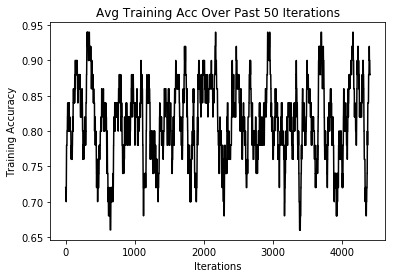

In [49]:
# Plot training accuracy over time
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.show()